<a href="https://colab.research.google.com/github/ebudd45/Meteorologyclass/blob/main/radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Magic to make Cartopy work-takes a few minutes
!pip install cartopy
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -q -c conda-forge cartopy
import cartopy
cartopy.__version__

✨🍰✨ Everything looks OK!


'0.22.0'

In [2]:
#Install needed modules
!pip install metpy
!pip install cartopy
!pip install siphon
!pip install netcdf4 h5netcdf
!pip install pydap

In [3]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.calc import azimuth_range_to_lat_lon
from metpy.plots import colortables, USSTATES, USCOUNTIES
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

In [4]:
date = datetime.utcnow()

# Create variables for URL generation
station = 'KLOT'

# Construct the data_url string
data_url = (f'https://thredds.ucar.edu/thredds/catalog/nexrad/level2/{station}/{date:%Y%m%d}/catalog.html')

# Get list of files available for particular day
cat = TDSCatalog(data_url)

# Grab dataset for desired time
dataset = cat.datasets.filter_time_nearest(date)

ds = xr.open_dataset(dataset.access_urls['OPENDAP'], decode_times=False,
                     decode_coords=False, mask_and_scale=True)

In [5]:
station = ds.Station
slat = ds.StationLatitude
slon = ds.StationLongitude
elevation = ds.StationElevationInMeters
vtime = datetime.strptime(ds.time_coverage_start, '%Y-%m-%dT%H:%M:%SZ')

sweep = 0
rng = ds.distanceR_HI.values
az = ds.azimuthR_HI.values[sweep]
ref = ds.Reflectivity_HI.values[sweep]

lon, lat = azimuth_range_to_lat_lon(az, rng, slon, slat)

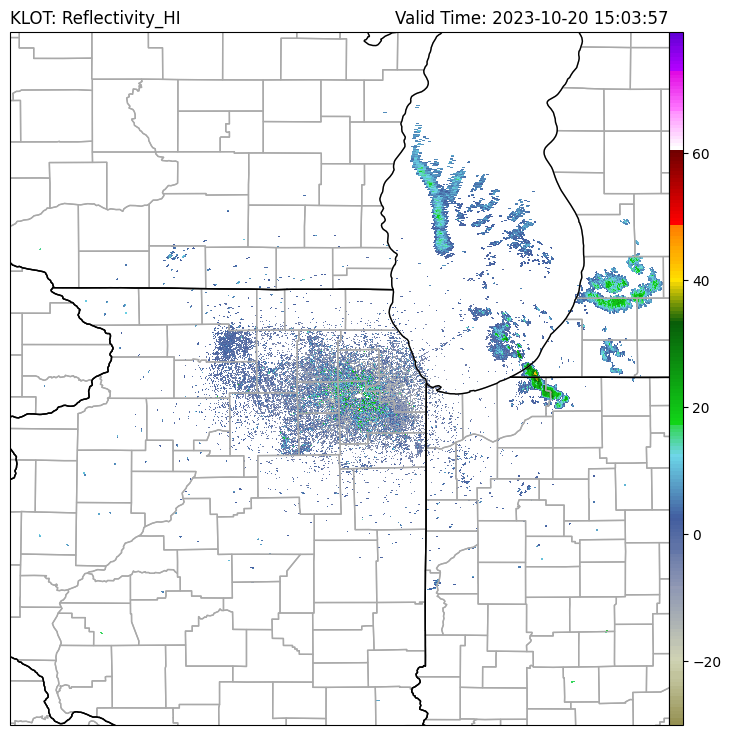

In [6]:
cmap = colortables.get_colortable('NWSStormClearReflectivity')

fig, ax = plt.subplots(1, 1, figsize=(10, 9), subplot_kw=dict(projection=ccrs.PlateCarree()))

img = ax.pcolormesh(lon, lat, ref, vmin=-30, vmax=79, cmap=cmap)
plt.colorbar(img, aspect=50, pad=0)

ax.set_extent([-91, -85.5, 40, 43.5], ccrs.PlateCarree())
ax.set_aspect('equal', 'datalim')

ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='darkgrey')
ax.add_feature(USSTATES.with_scale('5m'))

plt.title(f'{station}: {ds.Reflectivity_HI.name}', loc='left')
plt.title(f'Valid Time: {vtime}', loc='right')
plt.show()